<a href="https://colab.research.google.com/github/ketphan02/PiMA2019/blob/master/%5BPiMA_2019%5D%20Image%20Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download Kaggle

In [9]:
%pip install kaggle
%mkdir .kaggle

import os
os.environ['ketphan02'] = "7330ed814780b3a2ee975fc09a734599"
#Có thể lên kaggle để tạo tài khoản và sử dụng API của chính mình

import json
token = {"username":"ketphan02","key":"7330ed814780b3a2ee975fc09a734599"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

%mkdir ~/.kaggle/
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v/content
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘.kaggle’: File exists
mkdir: cannot create directory ‘/root/.kaggle/’: File exists
- path is now set to: /content


## Download dataset

In [10]:
!mkdir -p /content/dataset
%cd /content/dataset
!kaggle competitions download -c carvana-image-masking-challenge -f train.zip
!kaggle competitions download -c carvana-image-masking-challenge -f train_masks.csv.zip
!kaggle competitions download -c carvana-image-masking-challenge -f train_masks.zip

/content/dataset
 98% 398M/405M [00:06<00:00, 41.7MB/s]
100% 405M/405M [00:07<00:00, 60.5MB/s]
 33% 5.00M/15.3M [00:00<00:00, 10.9MB/s]
100% 15.3M/15.3M [00:00<00:00, 27.8MB/s]
 79% 23.0M/29.1M [00:00<00:00, 24.4MB/s]
100% 29.1M/29.1M [00:00<00:00, 65.6MB/s]


In [11]:
!mv /content/competitions/carvana-image-masking-challenge/train.zip /content/dataset/train.zip
!mv /content/competitions/carvana-image-masking-challenge/train_masks.zip /content/dataset/train_masks.zip
!mv /content/competitions/carvana-image-masking-challenge/train_masks.csv.zip /content/dataset/train_masks.csv.zip 
!rm -rf /content/competitions/
%cd /content/dataset/
!unzip -q train.zip
!unzip -q train_masks.zip
!unzip -q train_masks.csv.zip

/content/dataset


## Import tất cả thư viện cần

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

import skimage.io
from skimage.io import imread
from skimage.transform import resize

from pathlib import Path
import numpy as np 
import pandas as pd 
import cv2
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split

from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image 

import keras
from tensorflow.python.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Conv2DTranspose
from tensorflow.python.keras.activations import relu, sigmoid
from tensorflow.python.keras.optimizers import Adam

from tensorflow.python.keras import models
from tensorflow.python.keras import layers

Using TensorFlow backend.


## Data Preprocessing

In [0]:
BATCH_SIZE = 16
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_DIM = 3

raw_dir = '/content/dataset'
img_dir = raw_dir + "/train"
mask_dir = raw_dir + "/train_masks"

model_path = '/content/checkpoint/cp1.h5'

In [14]:
data_raw = pd.read_csv(os.path.join(raw_dir, 'train_masks.csv'))
ids_raw = data_raw['img'].map(lambda s: s.split('.')[0])
cnt_car = len(ids_raw) // 16 #each car has 16 images
lim_train = cnt_car*75 // 100
lim_val = lim_train + (cnt_car-lim_train) // 2 
lim_train *= 16
lim_val *= 16
x_train,y_train,x_test,y_test,x_val,y_val=[],[],[],[],[],[]

for i in range(len(ids_raw)):
  name = ids_raw[i]
  link_x = img_dir +'/{}.jpg'.format(name)
  link_y = mask_dir + '/{}_mask.gif'.format(name)
  
  if (i<lim_train): #for train
    x_train.append(link_x)
    y_train.append(link_y)
  elif (i<lim_val): #for validation
    x_val.append(link_x)
    y_val.append(link_y)
  else:
    x_test.append(link_x)
    y_test.append(link_y)
print('Train set: {0}'.format(len(x_train)))
print('Validation set: {0}'.format(len(x_val)))
print('Test set: {0}'.format(len(x_test)))

Train set: 3808
Validation set: 640
Test set: 640


In [0]:
def preprocessing(inp, mask):
  inp_img = tf.image.decode_jpeg(tf.read_file(inp), channels=3)
  inp_img = tf.image.resize_images(inp_img, (IMG_HEIGHT, IMG_WIDTH))
  inp_img = tf.reshape(inp_img,(IMG_HEIGHT, IMG_WIDTH,IMG_DIM)) 
  inp_img = inp_img / 255
  
  if mask != None:
    mask_img = tf.read_file(mask)
    mask_img = tf.image.decode_gif(mask_img)[0]
    mask_img = mask_img[:, :, 0]
    mask_img = tf.expand_dims(mask_img, axis=-1)
    mask_img = tf.image.resize_images(mask_img, (IMG_HEIGHT, IMG_WIDTH))
    mask_img = mask_img / 255
  else:
    mask_img = None
  return inp_img, mask_img

In [0]:
def generate_dataset(x, y, batch_size):  
  dataset = tf.data.Dataset.from_tensor_slices((x, y))
  
  dataset = dataset.map(preprocessing, num_parallel_calls=5)
  
  dataset = dataset.shuffle(len(x)).repeat().batch(batch_size)
  
  return dataset

In [0]:
ds_train = generate_dataset(x_train, y_train, BATCH_SIZE)
ds_val = generate_dataset(x_val, y_val, BATCH_SIZE)
ds_test = generate_dataset(x_test, y_test, BATCH_SIZE)

## Build model

In [0]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

def createModel():
  inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DIM))
  # 256
  
  encoder0_pool, encoder0 = encoder_block(inputs, 32)
  # 128
  
  encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
  # 64
  
  encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
  # 32
  
  encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
  # 16
  
  encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
  # 8
  
  center = conv_block(encoder4_pool, 1024)
  # center
  
  decoder4 = decoder_block(center, encoder4, 512)
  # 16
  
  decoder3 = decoder_block(decoder4, encoder3, 256)
  # 32
  
  decoder2 = decoder_block(decoder3, encoder2, 128)
  # 64
  
  decoder1 = decoder_block(decoder2, encoder1, 64)
  # 128
  
  decoder0 = decoder_block(decoder1, encoder0, 32)
  # 256
  
  outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)
  
  model = models.Model(inputs=[inputs], outputs=[outputs])
  
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])
  
  model.summary()
  
  return model

In [0]:
%mkdir /content/checkpoint/
cp = tf.keras.callbacks.ModelCheckpoint(filepath='/content/checkpoint/cp1.h5', save_best_only=True, verbose=1)

In [21]:
model = createModel()

W0814 05:05:45.715199 140569135961984 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0814 05:05:48.607223 140569135961984 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [22]:
EPOCHS=10
history = model.fit(ds_train, 
                   steps_per_epoch=int(np.ceil(len(x_train) / float(BATCH_SIZE))),
                   epochs=EPOCHS,
                   validation_data=ds_val,
                   validation_steps=int(np.ceil(len(x_val) / float(BATCH_SIZE))),
                   callbacks=[cp])

Epoch 1/10
237/238 [============================>.] - ETA: 1s - loss: 0.0741 - acc: 0.9831 - f1_m: 0.9639 - precision_m: 0.9590 - recall_m: 0.9697
Epoch 00001: val_loss improved from inf to 0.90389, saving model to /content/checkpoint/cp1.h5
238/238 [==============================] - 521s 2s/step - loss: 0.0739 - acc: 0.9832 - f1_m: 0.9640 - precision_m: 0.9591 - recall_m: 0.9698 - val_loss: 0.9039 - val_acc: 0.7829 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/10
237/238 [============================>.] - ETA: 1s - loss: 0.0199 - acc: 0.9940 - f1_m: 0.9862 - precision_m: 0.9854 - recall_m: 0.9871
Epoch 00002: val_loss improved from 0.90389 to 0.16326, saving model to /content/checkpoint/cp1.h5
238/238 [==============================] - 419s 2s/step - loss: 0.0199 - acc: 0.9940 - f1_m: 0.9862 - precision_m: 0.9854 - recall_m: 0.9871 - val_loss: 0.1633 - val_acc: 0.9605 - val_f1_m: 0.9009 - val_precision_m: 0.9972 - val_recall_m: 0.8219
Epoch 3/

##Show loss, accuracy, ... chart

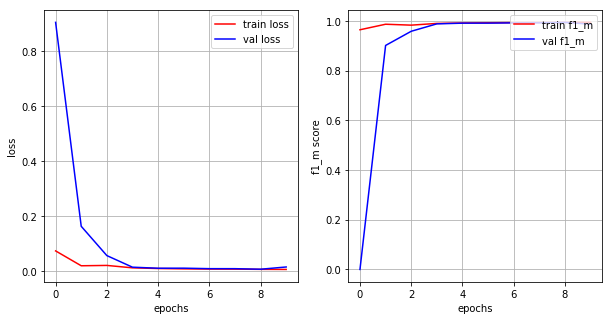

In [23]:
epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['loss'], 'r', label='train loss')
plt.plot(epochs_range, history.history['val_loss'], 'b', label='val loss')
plt.grid(True)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc="upper right")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['f1_m'], 'r', label='train f1_m')
plt.plot(epochs_range, history.history['val_f1_m'], 'b', label='val f1_m')
plt.grid(True)
plt.xlabel('epochs')
plt.ylabel('f1_m score')
plt.legend(loc="upper right")

plt.show()

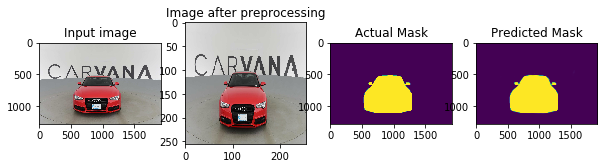

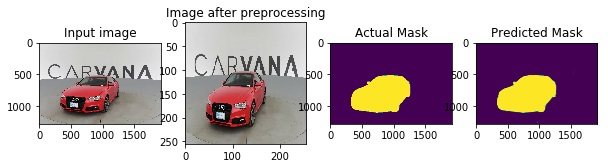

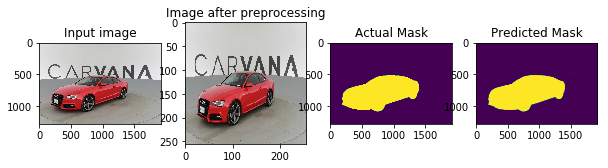

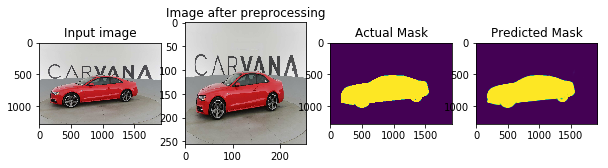

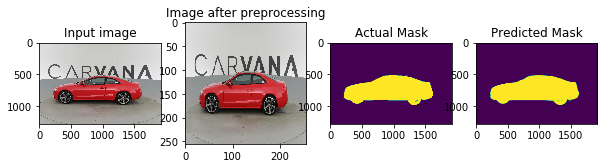

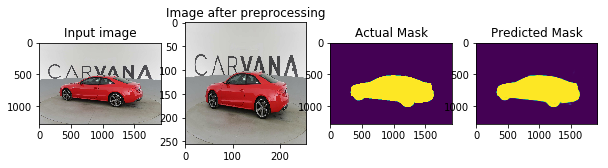

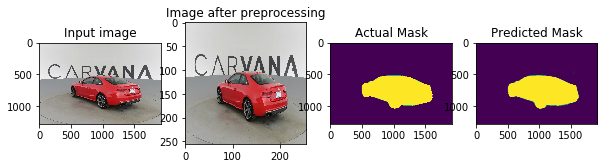

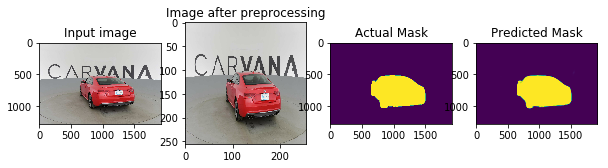

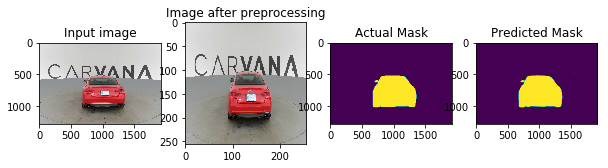

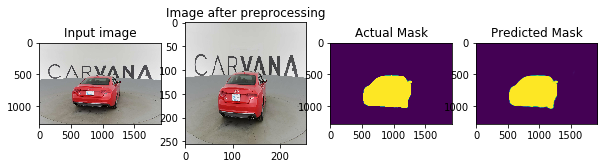

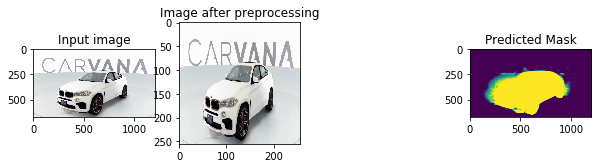

In [25]:
from PIL import Image
def Test(x,y=None):
  ++cntTest
  tmp = Image.open(x)
  WIDTH,HEIGHT=tmp.size
  
  plt.figure(figsize=(10, 20))
  img, mask = preprocessing(x,y)
  img=tf.Session().run(img)
  
  predicted_label = model.predict(img.reshape(1,IMG_HEIGHT,IMG_WIDTH,IMG_DIM))[0]
  plt.subplot(5, 4, 4 * cntTest + 1)
  plt.imshow(tmp)
  plt.title("Input image")
  plt.subplot(5, 4, 4 * cntTest + 2)
  plt.imshow(img)
  plt.title("Image after preprocessing")

  if y != None:
    mask=tf.image.resize_images(mask, (HEIGHT,WIDTH))
    mask=tf.Session().run(mask)
    plt.subplot(5, 4, 4 * cntTest + 3)
    plt.imshow(mask[:, :, 0])
    plt.title("Actual Mask")

  plt.subplot(5, 4, 4 * cntTest + 4)
  
  predicted_label=tf.convert_to_tensor(predicted_label,dtype=tf.float32)
  predicted_label=tf.image.resize_images(predicted_label,(HEIGHT,WIDTH))
  predicted_label=tf.Session().run(predicted_label)
  plt.imshow(predicted_label[:, :, 0])
  plt.title("Predicted Mask")
  plt.show()

cntTest=0
for i in range(10):
  Test(x_test[i],y_test[i])

#upload a ramdom picture to predict
# Test('/content/Test1.jpg')
Test('/content/Test2.jpg')

In [0]:
from google.colab import auth
auth.authenticate_user()